<a href="https://colab.research.google.com/github/MatteoFasulo/Sexism-detection/blob/main/assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
#%%capture
#!pip install requests umap nltk gensim

In [2]:
import os
import requests
from pathlib import Path
import re
import json
from typing import OrderedDict
import copy

import numpy as np
import pandas as pd

import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer

import gensim
import gensim.downloader as gloader

import torch

# Class definition

In [3]:
class SexismDetector:
    def __init__(self):

        URL_PATTERN_STR = r"""(?i)((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info
                      |int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|
                      bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|
                      cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|
                      gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|
                      la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|
                      nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|
                      sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|
                      uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]
                      *?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’])|(?:(?<!@)
                      [a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name
                      |post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn
                      |bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg
                      |eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id
                      |ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|
                      md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|
                      ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|
                      sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|
                      za|zm|zw)\b/?(?!@)))"""
        self.URL_PATTERN = re.compile(URL_PATTERN_STR, re.IGNORECASE)
        self.HASHTAG_PATTERN = re.compile(r'#\w*')
        self.MENTION_PATTERN = re.compile(r'@\w*')
        self.EMOJIS_PATTERN = re.compile(u'([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])')
        self.SPECIAL_CHARACTERS_PATTERN = re.compile(r'&lt;/?[a-z]+&gt;')
        self.AND_PATTERN = re.compile(r'&amp;')
        self.WORD_PATTERN = re.compile(r'[^a-zA-Z\s]')
        self.SEED = 42
        self.DATA_FOLDER = Path('data')
        self.MODEL_FOLDER = Path('models')
        self.columns_to_maintain = ['id_EXIST', 'lang', 'tweet', 'hard_label_task1']
        self.UNK_TOKEN = '[UNK]'
        self.PAD_TOKEN = '[PAD]'

    def download_corpus(self, url: str, filename: str) -> None:
        """
        Downloads a text corpus from a given URL and saves it to a specified filename within the data folder.

        Args:
            url (str): The URL from which to download the corpus.
            filename (str): The name of the file to save the downloaded corpus.

        Raises:
            requests.exceptions.HTTPError: If the HTTP request returned an unsuccessful status code.

        Side Effects:
            Creates the data folder if it does not exist.
            Writes the downloaded corpus to the specified file.
        """
        if not self.DATA_FOLDER.exists():
            self.DATA_FOLDER.mkdir(parents=True)
            print(f"Created folder {self.DATA_FOLDER}.")

        response = requests.get(url)
        response.raise_for_status()
        with open(self.DATA_FOLDER / filename, 'w', encoding='utf-8') as f:
            f.write(response.text)

    def load_corpus(self, filename: str, *args, **kwargs) -> pd.DataFrame:
        """
        Load a corpus from a JSON file.

        Parameters:
        filename (str): The name of the JSON file to load.
        *args: Variable length argument list to pass to pandas read_json.
        **kwargs: Arbitrary keyword arguments to pass to pandas read_json.

        Returns:
        DataFrame: A pandas DataFrame containing the loaded corpus.
        """
        return pd.read_json(self.DATA_FOLDER / filename, *args, **kwargs)

    @staticmethod
    def majority_voting(votes: list[str]) -> str:
        """
        Determines the majority vote from a list of votes.
        Args:
            votes (list[str]): A list of votes, where each vote is either "YES" or "NO".
        Returns:
            str: The result of the majority vote. Returns "YES" if there are more "YES" votes,
                "NO" if there are more "NO" votes, and "NEUTRAL" in case of a tie.
        """
        total_num_votes = len(votes)
        yes_votes = votes.count("YES")
        no_votes = total_num_votes - yes_votes

        if yes_votes > no_votes:
            return "YES"
        elif no_votes > yes_votes:
            return "NO"
        else:
            return "NEUTRAL" # This will be the case when there is a tie (removed later)

    def preprocess_text(self, text: str) -> str:
        """
        Preprocesses the input text by removing or replacing specific patterns.

        Args:
            text (str): The input text to be preprocessed.

        Returns:
            str: The preprocessed text with URLs, mentions, hashtags, emojis, 
                 special characters removed, 'and' replaced, and extra spaces trimmed.
        """
        text = self.URL_PATTERN.sub('', text)
        text = self.MENTION_PATTERN.sub('', text)
        text = self.HASHTAG_PATTERN.sub('', text)
        text = self.EMOJIS_PATTERN.sub('', text)
        text = self.SPECIAL_CHARACTERS_PATTERN.sub('', text)
        text = self.AND_PATTERN.sub('and', text)
        text = text.strip()
        text = self.WORD_PATTERN.sub(' ', text)
        text = text.strip()
        return text

    def lemmatize_text(self, text: str) -> str:
        """
        Lemmatizes the input text using the WordNet lemmatizer.

        This method attempts to lemmatize each word in the input text. If the WordNet
        data is not available, it will download the necessary data and retry.

        Args:
            text (str): The input text to be lemmatized.

        Returns:
            str: The lemmatized text.
        """
        lemmatizer = WordNetLemmatizer()
        downloaded = False
        while not downloaded:
            try:
                lemmatizer.lemmatize(text)
                downloaded = True
            except LookupError:
                print("Downloading WordNet...")
                nltk.download('wordnet')
        return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    @staticmethod
    def text_diff(original_text: str, preprocessed_text: str, random: bool = True) -> None:
        """
        Displays a comparison between an original tweet and its preprocessed version.
        Args:
            original_text (str): The original text data containing tweets.
            preprocessed_text (str): The preprocessed text data containing tweets.
            random (bool, optional): If True, a random tweet is selected for comparison. 
                                     If False, the first tweet is selected. Defaults to True.
        Returns:
            None
        """
        if random:
            idx = np.random.randint(0, preprocessed_text.shape[0])
        else:
            idx = 0

        print(f"Original tweet:\n{original_text['tweet'].iloc[idx]}")
        print(f"Processed tweet:\n{preprocessed_text['tweet'].iloc[idx]}")

    def load_glove(self, model_name: str = 'glove-wiki-gigaword', embedding_dim: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
        """
        Loads the GloVe model with the specified name and embedding dimension.
        Args:
            model_name (str): The name of the GloVe model to load. Default is 'glove-wiki-gigaword'.
            embedding_dim (int): The dimension of the word embeddings. Default is 50.
        Returns:
            gensim.models.keyedvectors.KeyedVectors: The loaded GloVe model.
        Raises:
            Exception: If there is an error in downloading or loading the model.
        Notes:
            - If the model folder does not exist, it will be created.
            - If the model is not already downloaded, it will be downloaded and saved to the specified path.
            - If the model is already downloaded, it will be loaded from the specified path.
        """
        self.EMBEDDING_DIM = embedding_dim

        if not self.MODEL_FOLDER.exists():
            self.MODEL_FOLDER.mkdir(parents=True)
            print(f"Created folder {self.MODEL_FOLDER}.")
        
        model_path = self.MODEL_FOLDER / f"{model_name}-{embedding_dim}"
        if not model_path.exists():
            print(f"Downloading {model_name} model...")
            glove_model = gloader.load(f"{model_name}-{embedding_dim}")
            print(f"Model downloaded! Saving to {model_path}")
            glove_model.save(str(model_path))
            print(f"Model saved to {self.MODEL_FOLDER / f'{model_name}-{embedding_dim}'}")
        else:
            glove_model = gensim.models.keyedvectors.KeyedVectors.load(str(model_path))
        return glove_model

    def get_vocab(self, data: pd.DataFrame, word_listing: list = None) -> tuple[OrderedDict, OrderedDict]:
        """
        Generates vocabulary mappings from a given dataset.
        Args:
            data (pd.DataFrame): A pandas DataFrame containing the dataset with a column 'tweet'.
            word_listing (list, optional): A list of words to include in the vocabulary. If None, the vocabulary
                                           will be built from the dataset. Defaults to None.
        Returns:
            tuple[OrderedDict, OrderedDict]: A tuple containing two OrderedDicts:
                - idx_to_word: Mapping from index to word.
                - word_to_idx: Mapping from word to index.
        """
        idx_to_word = OrderedDict()
        word_to_idx = OrderedDict()

        tokenizer = nltk.tokenize.NLTKWordTokenizer()

        if word_listing is None:
            curr_idx = 0
            for sentence in data['tweet'].values:
                tokens = tokenizer.tokenize(sentence)
                for token in tokens:
                    if token not in word_to_idx:
                        word_to_idx[token] = curr_idx
                        idx_to_word[curr_idx] = token
                        curr_idx += 1

        else:
            word_to_idx[self.UNK_TOKEN] = 0
            idx_to_word[0] = self.UNK_TOKEN

            curr_idx = 1
            for sentence in data['tweet'].values:
                tokens = sentence.split()
                for token in word_listing:
                    if token not in word_to_idx:
                        word_to_idx[token] = curr_idx
                        idx_to_word[curr_idx] = token
                        curr_idx += 1

        return idx_to_word, word_to_idx

    def get_augmented_vocab(self, emb_model: gensim.models.keyedvectors.KeyedVectors, train_words: list, save: bool = False) -> gensim.models.keyedvectors.KeyedVectors:
        """
        Augments the given embedding model with new tokens from the training words list. If a token is not found in the 
        embedding model, a random vector is generated for it. Optionally saves the updated vocabulary to a JSON file.
        Args:
            emb_model (gensim.models.keyedvectors.KeyedVectors): The embedding model to augment.
            train_words (list): A list of words to add to the embedding model.
            save (bool, optional): If True, saves the updated vocabulary to a JSON file. Defaults to False.
        Returns:
            gensim.models.keyedvectors.KeyedVectors: The augmented embedding model.
        """
        embedding_vocab = set(emb_model.key_to_index.keys())

        new_tokens = []
        new_vectors = []
        for token in train_words:
            if token not in embedding_vocab:
                embedding_vocab.add(token)
            try:
                embedding_vec = emb_model.get_vector(token)
            except (KeyError, ValueError):
                embedding_vec = np.random.uniform(low=-0.05, high=0.05, size=self.EMBEDDING_DIM)

            new_tokens.append(token)
            new_vectors.append(embedding_vec)

        emb_model.add_vectors(new_tokens, new_vectors)

        if save:
            vocab_path = self.DATA_FOLDER / 'vocab.json'
            print(f"Saving vocab to {vocab_path}")
            with vocab_path.open('w', encoding='utf-8') as f:
                json.dump(emb_model.key_to_index, f, indent=4)
            print("Vocab saved!")

        return emb_model

    def get_oov_stats(self, embedding_model: gensim.models.keyedvectors.KeyedVectors, word_listing: list) -> None:
        """
        Calculate and print the number and percentage of out-of-vocabulary (OOV) words.
        Args:
            embedding_model (gensim.models.keyedvectors.KeyedVectors): The word embedding model containing known words.
            word_listing (list): A list of words to check against the embedding model.
        Returns:
            None
        """
        OOV_count = set(word_listing).difference(set(embedding_model.key_to_index.keys()))
        OOV_percentage = float(len(OOV_count)) * 100 / len(word_listing)

        print(f"Total OOV terms: {len(OOV_count)} ({OOV_percentage:.2f}%)")

    def get_padded_sequences(self, data: pd.Series, embedding_model: gensim.models.keyedvectors.KeyedVectors) -> torch.Tensor:
        """
        Converts a pandas Series of text data into padded sequences of word indices using a given embedding model.

        Args:
            data (pd.Series): A pandas Series containing text data.
            embedding_model (gensim.models.keyedvectors.KeyedVectors): A pre-trained word embedding model.

        Returns:
            torch.Tensor: A tensor containing padded sequences of word indices.
        """
        tokenizer = nltk.tokenize.NLTKWordTokenizer()
        unk_index = embedding_model.get_index(self.UNK_TOKEN)

        sequences = [torch.tensor([embedding_model.get_index(word, default=unk_index) for word in tokenizer.tokenize(x)]) for x in data.values]
        
        return torch.nn.utils.rnn.pad_sequence(sequences, padding_value=embedding_model.get_index(self.PAD_TOKEN), batch_first=True)

    def get_dataloader(self):
        return

    @staticmethod
    def visualize_embeddings(embeddings: np.ndarray,
                         word_annotations,
                         word_to_idx):
        """
        Plots given reduce word embeddings (2D). Users can highlight specific words (word_annotations list).

        :param embeddings: word embedding matrix of shape (words, 2) retrieved via a dimensionality reduction technique.
        :param word_annotations: list of words to be annotated.
        :param word_to_idx: vocabulary map (word -> index) (dict)
        """
        fig, ax = plt.subplots(1, 1, figsize=(15, 12))

        if word_annotations:
            print(f"Annotating words: {word_annotations}")

            word_indexes = []
            for word in word_annotations:
                word_index = word_to_idx[word]
                word_indexes.append(word_index)

            word_indexes = np.array(word_indexes)

            other_embeddings = embeddings[np.setdiff1d(np.arange(embeddings.shape[0]), word_indexes)]
            target_embeddings = embeddings[word_indexes]

            ax.scatter(other_embeddings[:, 0], other_embeddings[:, 1], alpha=0.1, c='blue')
            ax.scatter(target_embeddings[:, 0], target_embeddings[:, 1], alpha=1.0, c='red')
            ax.scatter(target_embeddings[:, 0], target_embeddings[:, 1], alpha=1, facecolors='none', edgecolors='r', s=1000)

            for word, word_index in zip(word_annotations, word_indexes):
                word_x, word_y = embeddings[word_index, 0], embeddings[word_index, 1]
                ax.annotate(word, xy=(word_x, word_y))
        else:
            ax.scatter(embeddings[:, 0], embeddings[:, 1], alpha=0.1, c='blue')

        # We avoid outliers ruining the visualization if they are quite far away
        axis_x_limit = (np.min(embeddings[:, 0]), np.max(embeddings[:, 0]))
        axis_y_limit = (np.min(embeddings[:, 1]), np.max(embeddings[:, 1]))
        plt.xlim(left=axis_x_limit[0] - 0.5, right=axis_x_limit[1] + 0.5)
        plt.ylim(bottom=axis_y_limit[0] - 0.5, top=axis_y_limit[1] + 0.5)
        ax.set_xlim(axis_x_limit[0], axis_x_limit[1])
        ax.set_ylim(axis_y_limit[0], axis_y_limit[1])

    @staticmethod
    def reduce_SVD(embeddings: np.ndarray) -> np.ndarray:
        """
        Applies SVD dimensionality reduction.

        :param embeddings: word embedding matrix of shape (words, dim). In the case
                        of a word-word co-occurrence matrix the matrix shape would
                        be (words, words).

        :return
            - 2-dimensional word embedding matrix of shape (words, 2)
        """
        print("Running SVD reduction method...")
        svd = TruncatedSVD(n_components=2, n_iter=10)
        reduced = svd.fit_transform(embeddings)
        print("SVD reduction completed!")

        return reduced

    @staticmethod
    def reduce_tSNE(embeddings: np.ndarray) -> np.ndarray:
        """
        Applies t-SNE dimensionality reduction.
        """
        print("Running t-SNE reduction method... (it may take a while...)")
        tsne = TSNE(n_components=2, n_iter=1000, metric='cosine')
        reduced = tsne.fit_transform(embeddings)
        print("t-SNE reduction completed!")

        return reduced

    @staticmethod
    def reduce_umap(embeddings: np.ndarray) -> np.ndarray:
        """
        Applies UMAP dimensionality reduction.
        """
        print("Running UMAP reduction method... (it may take a while...)")
        umap_emb = umap.UMAP(n_components=2, metric='cosine')
        reduced = umap_emb.fit_transform(embeddings)
        print("UMAP reduction completed!")

        return reduced


# Task 1: Corpus

1. Download the data
2. Load the JSON files and encode them as a DataFrame
3. Generate hard labels for Task 1 with majority voting
4. Filter the DataFrame for only english tweets
5. Remove unwanted columns
6. Encode the hard labels column as integers

>**Bonus**: explore also Spanish tweets leveraging multi-language models and assessing the performance of the model on the two languages in comparison to the English-only model.

In [4]:
detector = SexismDetector()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
torch.cuda.manual_seed(detector.SEED)
np.random.seed(detector.SEED)

In [7]:
EMBEDDING_DIM = 100
BATCH_SIZE = 32

### Download the data

In [8]:
detector.download_corpus(url='https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%201/data/training.json', filename='training.json')
detector.download_corpus(url='https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%201/data/test.json', filename='test.json')
detector.download_corpus(url='https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%201/data/validation.json', filename='validation.json')

### Load the JSON files and encode them as a DataFrame

In [9]:
train = detector.load_corpus('training.json', orient='index', encoding='utf-8')
test = detector.load_corpus('test.json', orient='index', encoding='utf-8')
val = detector.load_corpus('validation.json', orient='index', encoding='utf-8')

In [10]:
train.head()

,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
100001,100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, YES, NO, YES, YES, YES]","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[[OBJECTIFICATION], [OBJECTIFICATION, SEXUAL-V...",TRAIN_ES
100002,100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, YES, NO]","[-, -, -, -, DIRECT, -]","[[-], [-], [-], [-], [OBJECTIFICATION], [-]]",TRAIN_ES
100003,100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES
100004,100004,es,@Lunariita7 Un retraso social bastante lamenta...,6,"[Annotator_13, Annotator_14, Annotator_15, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, YES, NO, YES, YES]","[-, -, DIRECT, -, REPORTED, REPORTED]","[[-], [-], [IDEOLOGICAL-INEQUALITY], [-], [IDE...",TRAIN_ES
100005,100005,es,@novadragon21 @icep4ck @TvDannyZ Entonces como...,6,"[Annotator_19, Annotator_20, Annotator_21, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, NO, YES, NO, YES, YES]","[REPORTED, -, JUDGEMENTAL, -, JUDGEMENTAL, DIR...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION], [-...",TRAIN_ES


In [11]:
train.shape, val.shape, test.shape

((6920, 11), (726, 11), (312, 11))

### Generate hard labels for Task 1 with majority voting

In [12]:
train['hard_label_task1'] = train['labels_task1'].apply(detector.majority_voting)
val['hard_label_task1'] = val['labels_task1'].apply(detector.majority_voting)
test['hard_label_task1'] = test['labels_task1'].apply(detector.majority_voting)

### Filter the DataFrame for only english tweets and remove unclear tweets

In [13]:
train = train[(train['hard_label_task1'] != "NEUTRAL") & (train['lang'] == "en")]
val = val[(val['hard_label_task1'] != "NEUTRAL") & (val['lang'] == "en")]
test = test[(test['hard_label_task1'] != "NEUTRAL") & (test['lang'] == "en")]

In [14]:
train.shape, val.shape, test.shape

((2870, 12), (158, 12), (286, 12))

### Remove unwanted columns

In [15]:
train = train[detector.columns_to_maintain]
val = val[detector.columns_to_maintain]
test = test[detector.columns_to_maintain]

In [16]:
train.head()

,id_EXIST,lang,tweet,hard_label_task1
200002,200002,en,Writing a uni essay in my local pub with a cof...,YES
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,YES
200006,200006,en,According to a customer I have plenty of time ...,YES
200007,200007,en,"So only 'blokes' drink beer? Sorry, but if you...",YES
200008,200008,en,New to the shelves this week - looking forward...,NO


### Encode the hard labels column as integers

In [17]:
train['hard_label_task1'] = train['hard_label_task1'].apply(lambda x: 1 if x == "YES" else 0)
val['hard_label_task1'] = val['hard_label_task1'].apply(lambda x: 1 if x == "YES" else 0)
test['hard_label_task1'] = test['hard_label_task1'].apply(lambda x: 1 if x == "YES" else 0)

In [18]:
train.hard_label_task1.value_counts()

hard_label_task1
0    1733
1    1137
Name: count, dtype: int64

# Task 2: Data Cleaning

1. Remove emojis
2. Remove hashtags (e.g. #metoo)
3. Remove mentions (e.g. @user)
4. Remove URLs
5. Remove special characters and symbols
6. Remove specific quote characters (e.g. curly quotes)
7. Perform lemmatization

>**Bonus**: use other preprocessing strategies exploring techniques tailored specifically for tweets or methods that are common in social media text processing.

The way to go (priority order) is the following:
1. Remove URLs
2. Remove mentions
3. Remove hashtags
4. Remove emojis
5. Remove special characters
6. Remove specific quote characters
7. Perform lemmatization

In [19]:
original_train = train.copy()

In [20]:
train['tweet'] = train['tweet'].apply(detector.preprocess_text)
val['tweet'] = val['tweet'].apply(detector.preprocess_text)
test['tweet'] = test['tweet'].apply(detector.preprocess_text)

### Perform lemmatization

In [21]:
train['tweet'] = train['tweet'].apply(detector.lemmatize_text)
val['tweet'] = val['tweet'].apply(detector.lemmatize_text)
test['tweet'] = test['tweet'].apply(detector.lemmatize_text)

### Cast text to lowercase

In [22]:
train['tweet'] = train['tweet'].str.lower()
val['tweet'] = val['tweet'].str.lower()
test['tweet'] = test['tweet'].str.lower()

### Show the difference between the original and cleaned text

In [23]:
detector.text_diff(preprocessed_text=train, original_text=original_train, random=True)

Original tweet:
at the same time the exoticization - sometimes self-exoticization - I see of cultural outputs from countries like Japan or Korea, which presupposes that those cultures are SO different that EU/US folks couldn’t POSSIBLY understand… it’s a whole thing.
Processed tweet:
at the same time the exoticization sometimes self exoticization i see of cultural output from country like japan or korea which presupposes that those culture are so different that eu us folk couldn t possibly understand it s a whole thing


# Task 3: Text Encoding

* Embed words using GloVe embeddings.

### Embed words using GloVe embeddings

In [24]:
emb_model = detector.load_glove(model_name='glove-twitter', embedding_dim=EMBEDDING_DIM)
print(f"Vocabulary size: {len(emb_model.key_to_index)}")

Vocabulary size: 1193514


Get the training vocabulary and generate the list of words appearing in the training set.

In [25]:
train_idx_to_word, train_word_to_idx = detector.get_vocab(train)
train_word_listing = list(train_idx_to_word.values())

Inspect how many words in the training set are not in the GloVe vocabulary.

In [26]:
detector.get_oov_stats(emb_model, train_word_listing)

Total OOV terms: 791 (8.03%)


Merge the training set vocabulary with the GloVe vocabulary and generate the embedding vectors for the words in the training set that do not appear in the GloVe vocabulary.

In [27]:
emb_model_augmented = detector.get_augmented_vocab(emb_model, train_words=train_word_listing, save=True)

Saving vocab to data\vocab.json
Vocab saved!


Add the two special reserved token embeddings for unknown and padding tokens. The first one is used for words that are not in the vocabulary, and the second one is used for padding. The unknown token is initialized with the average of the embeddings, and the padding token is initialized with zeros.

In [28]:
# add the UNK token to the embedding model with the vector which is the average of all the vectors
emb_model_augmented.add_vectors(["[UNK]", "[PAD]"], [np.mean(emb_model_augmented.vectors, axis=0), np.zeros(EMBEDDING_DIM)])

Now we can create the embedding matrix that will be used in the model.

In [29]:
### Create the embeddings matrix
embedding_matrix = emb_model_augmented.vectors
print(f"Embedding matrix has {embedding_matrix.shape[0]} vectors (tokens), each of dimension {embedding_matrix.shape[1]}")

Embedding matrix has 1194307 vectors (tokens), each of dimension 100


We can also visualize the embeddings using UMAP (but this is optional).

In [30]:
# UMAP
#reduced_embedding_umap = detector.reduce_umap(embedding_matrix)
#detector.visualize_embeddings(reduced_embedding_umap, ['whore', 'woman', 'slut', 'girl', 'man', 'boy'], emb_model.key_to_index)

#plt.show()

# Task 4: Model definition

* Baseline: Implement a Bidirectional LSTM with a Dense layer on top.
* Model 1: add an additional LSTM layer to the baseline model.

### Baseline: Implement a Bidirectional LSTM with a Dense layer on top

In [31]:
class BaselineLSTM(torch.nn.Module):
    def __init__(self, embedding_model, hidden_dim, output_dim: int = 1, lstm_layers: int = 1):
        super(BaselineLSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.lstm_layers = lstm_layers

        self.word_embeddings = torch.nn.Embedding.from_pretrained(
            embeddings=torch.from_numpy(embedding_model.vectors),
            freeze=True,
            padding_idx=embedding_model.get_index(detector.PAD_TOKEN),
            norm_type=2,
        )
        self.dropout = torch.nn.Dropout(0.5)
        self.lstm = torch.nn.LSTM(input_size=embedding_model.vector_size, hidden_size=hidden_dim, bidirectional=True, num_layers=lstm_layers, batch_first=True)
        self.fc1 = torch.nn.Linear(in_features=2 * hidden_dim, out_features=hidden_dim)
        self.fc2 = torch.nn.Linear(in_features=hidden_dim, out_features=output_dim)
        self.hidden_dim = hidden_dim
    
    def forward(self, inputs):
        h = torch.zeros(2 * self.lstm_layers, inputs.size(0), self.hidden_dim).to(device)
        c = torch.zeros(2 * self.lstm_layers, inputs.size(0), self.hidden_dim).to(device)

        torch.nn.init.xavier_normal_(h)
        torch.nn.init.xavier_normal_(c)

        out = self.word_embeddings(inputs)
        out, (hidden, cell) = self.lstm(out, (h,c))
        out = self.dropout(out)
        out = self.fc1(out[:,-1,:])
        out = self.fc2(out)
        return out

In [80]:
baseline_model = BaselineLSTM(emb_model_augmented, hidden_dim=128, lstm_layers=1)
baseline_model.to(device)

BaselineLSTM(
  (word_embeddings): Embedding(1194307, 100, padding_idx=1194306)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(100, 128, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [81]:
loss_function = torch.nn.BCEWithLogitsLoss(reduction='none')
optimizer = torch.optim.AdamW(baseline_model.parameters(), lr=1e-2, weight_decay=1e-5)

# Task 5: Training and Evaluation

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.
* Evaluate your models using macro F1-score.

Before training the models we need to encode the input data and the labels. The input data is the text, and the labels are the hard labels generated with majority voting. Now, the text must be encoded using the GloVe embeddings indices.

In [82]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return self.sequences.shape[0]

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

In [83]:
train_dset = TextDataset(detector.get_padded_sequences(train['tweet'], emb_model_augmented), torch.tensor(train['hard_label_task1'].values))
val_dset = TextDataset(detector.get_padded_sequences(val['tweet'], emb_model_augmented), torch.tensor(val['hard_label_task1'].values))
test_dset = TextDataset(detector.get_padded_sequences(test['tweet'], emb_model_augmented), torch.tensor(test['hard_label_task1'].values))

In [84]:
train_dloader = torch.utils.data.DataLoader(dataset=train_dset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_dloader = torch.utils.data.DataLoader(dataset=val_dset, batch_size=BATCH_SIZE, shuffle=False)
test_dloader = torch.utils.data.DataLoader(dataset=test_dset, batch_size=BATCH_SIZE, shuffle=False)

In [85]:
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, lr_mul, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.lr_mul = lr_mul
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0


    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()


    def zero_grad(self):
        "Zero out the gradients with the inner optimizer"
        self._optimizer.zero_grad()


    def _get_lr_scale(self):
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_steps * n_warmup_steps ** (-1.5))


    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_steps += 1
        lr = self.lr_mul * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

In [86]:
sched = ScheduledOptim(optimizer=optimizer, lr_mul=1, d_model=256, n_warmup_steps=512)

In [87]:
history = pd.DataFrame(columns=['epoch', 'train_loss', 'val_loss', 'train_acc', 'val_acc', 'learning_rate'])

In [88]:
def train_model(model, training_data, validation_data, loss_function, optimizer, num_epochs, patience: int = 20, verbose: bool = False):
    # Initialize parameters of Early stopping
    best_val_loss = np.inf
    best_model = None
    best_model_epoch = 0

    # Initialize the Scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, steps_per_epoch=len(training_data), epochs=num_epochs)
    # Train the model
    for epoch in range(num_epochs):
        train_correct = 0
        train_total = 0

        # Last 10 epochs, unfreeze the embeddings
        #if epoch == 30:
        #    model.word_embeddings.weight.requires_grad = True
        #    # Reduce the learning rate
        #    for param_group in optimizer.param_groups:
        #        param_group['lr'] = 1e-5

        model.train()
        for i, batch in enumerate(training_data):
            sentence, labels = batch

            model.zero_grad()
            sched.zero_grad()

            sentence = sentence.to(device)
            labels = labels.unsqueeze(1).float().to(device)

            output = model(sentence)

            loss = loss_function(output, labels)
            loss_mask = labels != emb_model_augmented.get_index(detector.PAD_TOKEN)
            loss_masked = loss.where(loss_mask, torch.tensor(0.0))
            mean_loss = loss_masked.sum() / loss_mask.sum()

            mean_loss.backward()
            optimizer.step()
            #scheduler.step()
            sched.step_and_update_lr()

            predicted = (output > 0.5).float()
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        model.eval()
        final_val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for i, batch in enumerate(validation_data):
                sentence, labels = batch

                sentence = sentence.to(device)
                labels = labels.unsqueeze(1).float().to(device)

                output = model(sentence)

                val_loss = loss_function(output, labels)
                loss_mask = labels != emb_model_augmented.get_index(detector.PAD_TOKEN)
                loss_masked = val_loss.where(loss_mask, torch.tensor(0.0))
                mean_val_loss = loss_masked.sum() / loss_mask.sum()

                final_val_loss += mean_val_loss.item()

                predicted = (output > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        final_val_loss /= len(validation_data)

        # Early stopping
        if final_val_loss < best_val_loss:
            best_val_loss = final_val_loss
            best_model = copy.deepcopy(model.state_dict())
            best_model_epoch = epoch
            patience = 7
        else:
            patience -= 1
            if patience == 0:
                print(f"Early stopping at epoch {epoch + 1}, best model with val loss: {best_val_loss:.4f} at epoch {best_model_epoch + 1}")
                break

        if verbose:
            print(f"Epoch {epoch + 1}/{num_epochs}\tLoss: {mean_loss.item():.4f}\tAcc: {train_correct / train_total:.4f}\tVal Loss: {final_val_loss:.4f}\tVal Acc: {val_correct / val_total:.4f}\tlr: {sched._get_lr_scale():.5f}")
        
        # Save the history
        history.loc[len(history)] = [epoch + 1, mean_loss.item(), final_val_loss, train_correct / train_total, val_correct / val_total, sched._get_lr_scale()]
    
    # Restore the best model
    model.load_state_dict(best_model)

    # Save the best model
    torch.save(model.state_dict(), detector.MODEL_FOLDER / 'baseline_lstm.pth')
    
    return model

In [89]:
best_model = train_model(baseline_model, train_dloader, val_dloader, loss_function, optimizer, num_epochs=50, verbose=True)

Epoch 1/50	Loss: 0.6743	Acc: 0.6038	Val Loss: 0.6831	Val Acc: 0.5696	lr: 0.00049
Epoch 2/50	Loss: 0.6818	Acc: 0.6045	Val Loss: 0.6754	Val Acc: 0.5823	lr: 0.00097
Epoch 3/50	Loss: 0.6331	Acc: 0.6049	Val Loss: 0.6720	Val Acc: 0.5696	lr: 0.00146
Epoch 4/50	Loss: 0.6673	Acc: 0.6063	Val Loss: 0.6832	Val Acc: 0.5696	lr: 0.00194
Epoch 5/50	Loss: 0.6895	Acc: 0.6042	Val Loss: 0.6962	Val Acc: 0.5759	lr: 0.00243
Epoch 6/50	Loss: 0.7423	Acc: 0.6038	Val Loss: 0.6925	Val Acc: 0.5696	lr: 0.00269
Epoch 7/50	Loss: 0.6215	Acc: 0.6038	Val Loss: 0.6795	Val Acc: 0.5696	lr: 0.00249
Epoch 8/50	Loss: 0.6633	Acc: 0.6031	Val Loss: 0.6853	Val Acc: 0.5696	lr: 0.00233
Epoch 9/50	Loss: 0.6741	Acc: 0.6042	Val Loss: 0.6789	Val Acc: 0.5886	lr: 0.00220
Epoch 10/50	Loss: 0.5558	Acc: 0.6300	Val Loss: 0.5216	Val Acc: 0.7152	lr: 0.00208
Epoch 11/50	Loss: 0.3276	Acc: 0.7045	Val Loss: 0.4946	Val Acc: 0.7468	lr: 0.00199
Epoch 12/50	Loss: 0.5177	Acc: 0.7509	Val Loss: 0.4528	Val Acc: 0.7658	lr: 0.00190
Epoch 13/50	Loss: 0.3201	

In [92]:
torch.cuda.empty_cache()

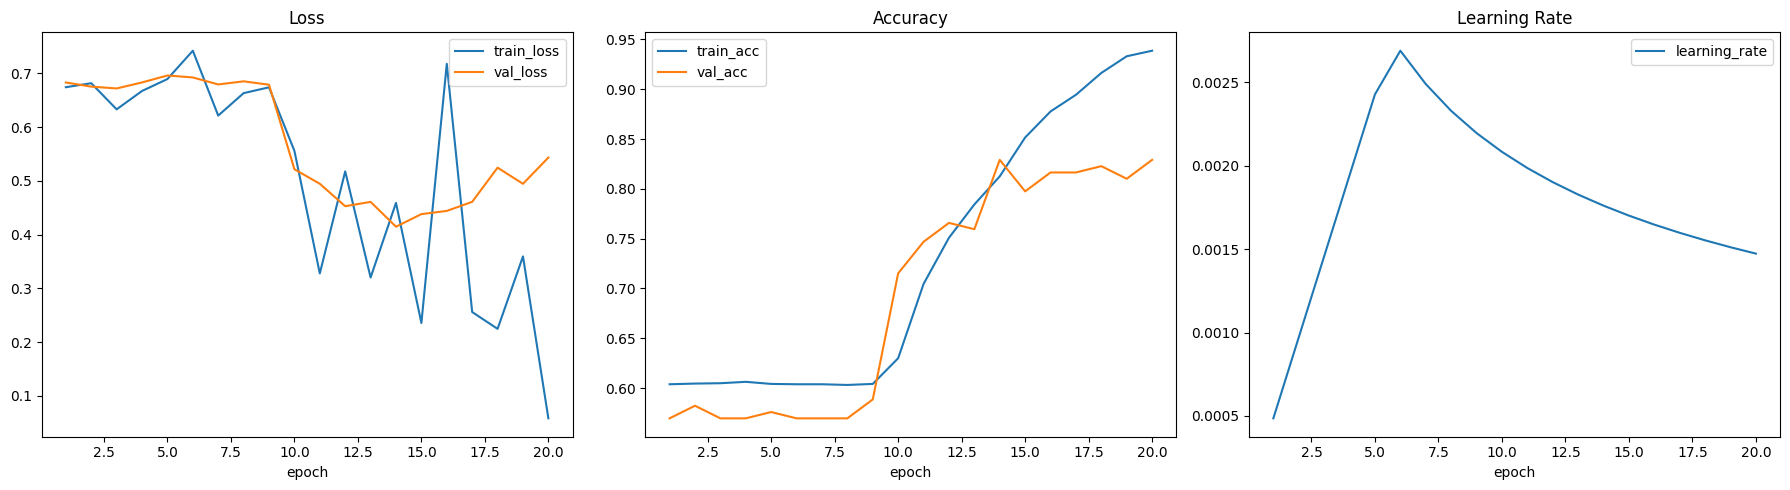

In [93]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

history.plot(x='epoch', y=['train_loss', 'val_loss'], title='Loss', ax=axes[0])
history.plot(x='epoch', y=['train_acc', 'val_acc'], title='Accuracy', ax=axes[1])
history.plot(x='epoch', y='learning_rate', title='Learning Rate', ax=axes[2])

plt.tight_layout()
plt.show()

# Task 6: Transformers

# Task 7: Error Analysis

# Task 8: Report